In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import math
from collections import defaultdict

import music21

In [3]:
MIDI_FILE = 'clean_midi/Daft Punk/Around the World   Harder Better Faster Stronger.1.mid'

In [4]:
with open(MIDI_FILE, 'rb') as f:
    mf = music21.midi.MidiFile()
    mf.openFileLike(f)
    mf.read()

In [5]:
mf.ticksPerQuarterNote

384

In [6]:
track_1 = mf.tracks[1]

In [7]:
stream = music21.midi.translate.midiFileToStream(mf)
stream.quantize((4, 3))

<music21.stream.Score 0x11855aad0>

In [8]:
SAMPLE_FREQ = 4 # samples per quarter note

In [9]:
note_filter = music21.stream.filters.ClassFilter('Note')

In [10]:
def instrument_filter(inst):
    return 'bass' in str(inst).lower()

In [11]:
duration = music21.duration.Duration(0.0625)

In [43]:
class Track(object):
    @staticmethod
    def encode_notes(notes, sample_freq=4, transpose=0):
        """
        Return a list-of-strings representation of the notes for downstream tasks (language modelling)
        """
        encoded = []
        for note in notes:
            # NOTE: We'll make a sort of crude approximation of the musical sequence here
            # Passing in a quantized stream will help reduce these though. Further thought required.
            duration = math.floor(note.duration.quarterLength * sample_freq)
            
            if isinstance(note, music21.note.Note):
                midi_pitch = note.pitch.midi + transpose
                tok = f'S-{midi_pitch}'
                encoded.append(tok)
                encoded += [f'H-{midi_pitch}' for _ in range(duration - 1)]
            elif isinstance(note, music21.note.Rest):
                encoded += ['R' for _ in range(duration)]
        return encoded
    
    @staticmethod
    def decode_notes(enc_notes, sample_freq=4):
        """
        Return a list of music21.note.Note/Rest instances from a list-of-strings representation sampled at the
        specified sample frequency.
        """
        
        notes = []
        curr_note = None
        duration_inc = 1 / sample_freq
        
        for enc in enc_notes:
            if 'S-' in enc:
                curr_note = music21.note.Note()
                notes.append(curr_note)
                curr_note.pitch.midi = int(enc.replace('S-', ''))
                curr_note.duration = music21.duration.Duration(duration_inc)
            elif 'H-' in enc:
                curr_note.duration.quarterLength += duration_inc
            elif 'R' in enc:
                curr_note = music21.note.Rest()
                notes.append(curr_note)
                curr_note.duration = music21.duration.Duration(duration_inc)
        return notes
    
    def __init__(self, name, notes):
        self.name = name
        self.notes = notes # music21.note.Note/Rest instances
    
    def encode(self, transpose=0):
        return self.encode_notes(self.notes, transpose)
    
    def track_range(self):
        pitches = [note.pitch.midi for note in self.notes if isinstance(note, music21.note.Note)]
        return (min(pitches), max(pitches))
    
    def encode_many(self, rng=(24, 75)):
        """
        Returns a list of enccodings that fit between the provided range and preserve the original
        note relationships (if any can).
        """
        rng_min, rng_max = rng
        pitch_min, pitch_max = self.track_range()
        
        trans_min = rng_min - pitch_min
        trans_max = trans_min + (rng_max - pitch_max)
        
        encodings = []
        
        if (rng_max - rng_min) < (pitch_max - pitch_min):
            return encodings
        
        for transpose in range(trans_min, trans_max + 1):
            encodings.append(self.encode(transpose=transpose))
        return encodings
    

In [44]:
class TrackCollection(object):
    def __init__(self, tracks):
        self.tracks = tracks
    
    @classmethod
    def load(cls, stream, instrument_filter=None):
        note_seqs = defaultdict(list)        
        for action in stream.recurse(classFilter=('Note', 'Rest')):
            instrument = action.activeSite.getInstrument()
            if instrument_filter and not instrument_filter(instrument):
                continue
            
            instr_name = str(instrument)
            note_seqs[instr_name].append(action)
        
        return cls({instr_name: Track(instr_name, notes) for intr_name, notes in note_seqs.items()})
        

In [45]:
tracks = TrackCollection.load(stream, instrument_filter)

In [46]:
len(tracks.tracks['Fretless Bass'].encode_many())

36

In [15]:
recoded_notes = Track.decode_notes(tracks.tracks['Fretless Bass'].encode())

In [20]:
recoded_stream = music21.stream.Stream()
for note in recoded_notes:
    recoded_stream.append(note)

In [24]:
test_note = music21.note.Note('D1')

In [32]:
range([n.pitch.midi for n in recoded_notes if isinstance(n, music21.note.Note)])

TypeError: 'list' object cannot be interpreted as an integer

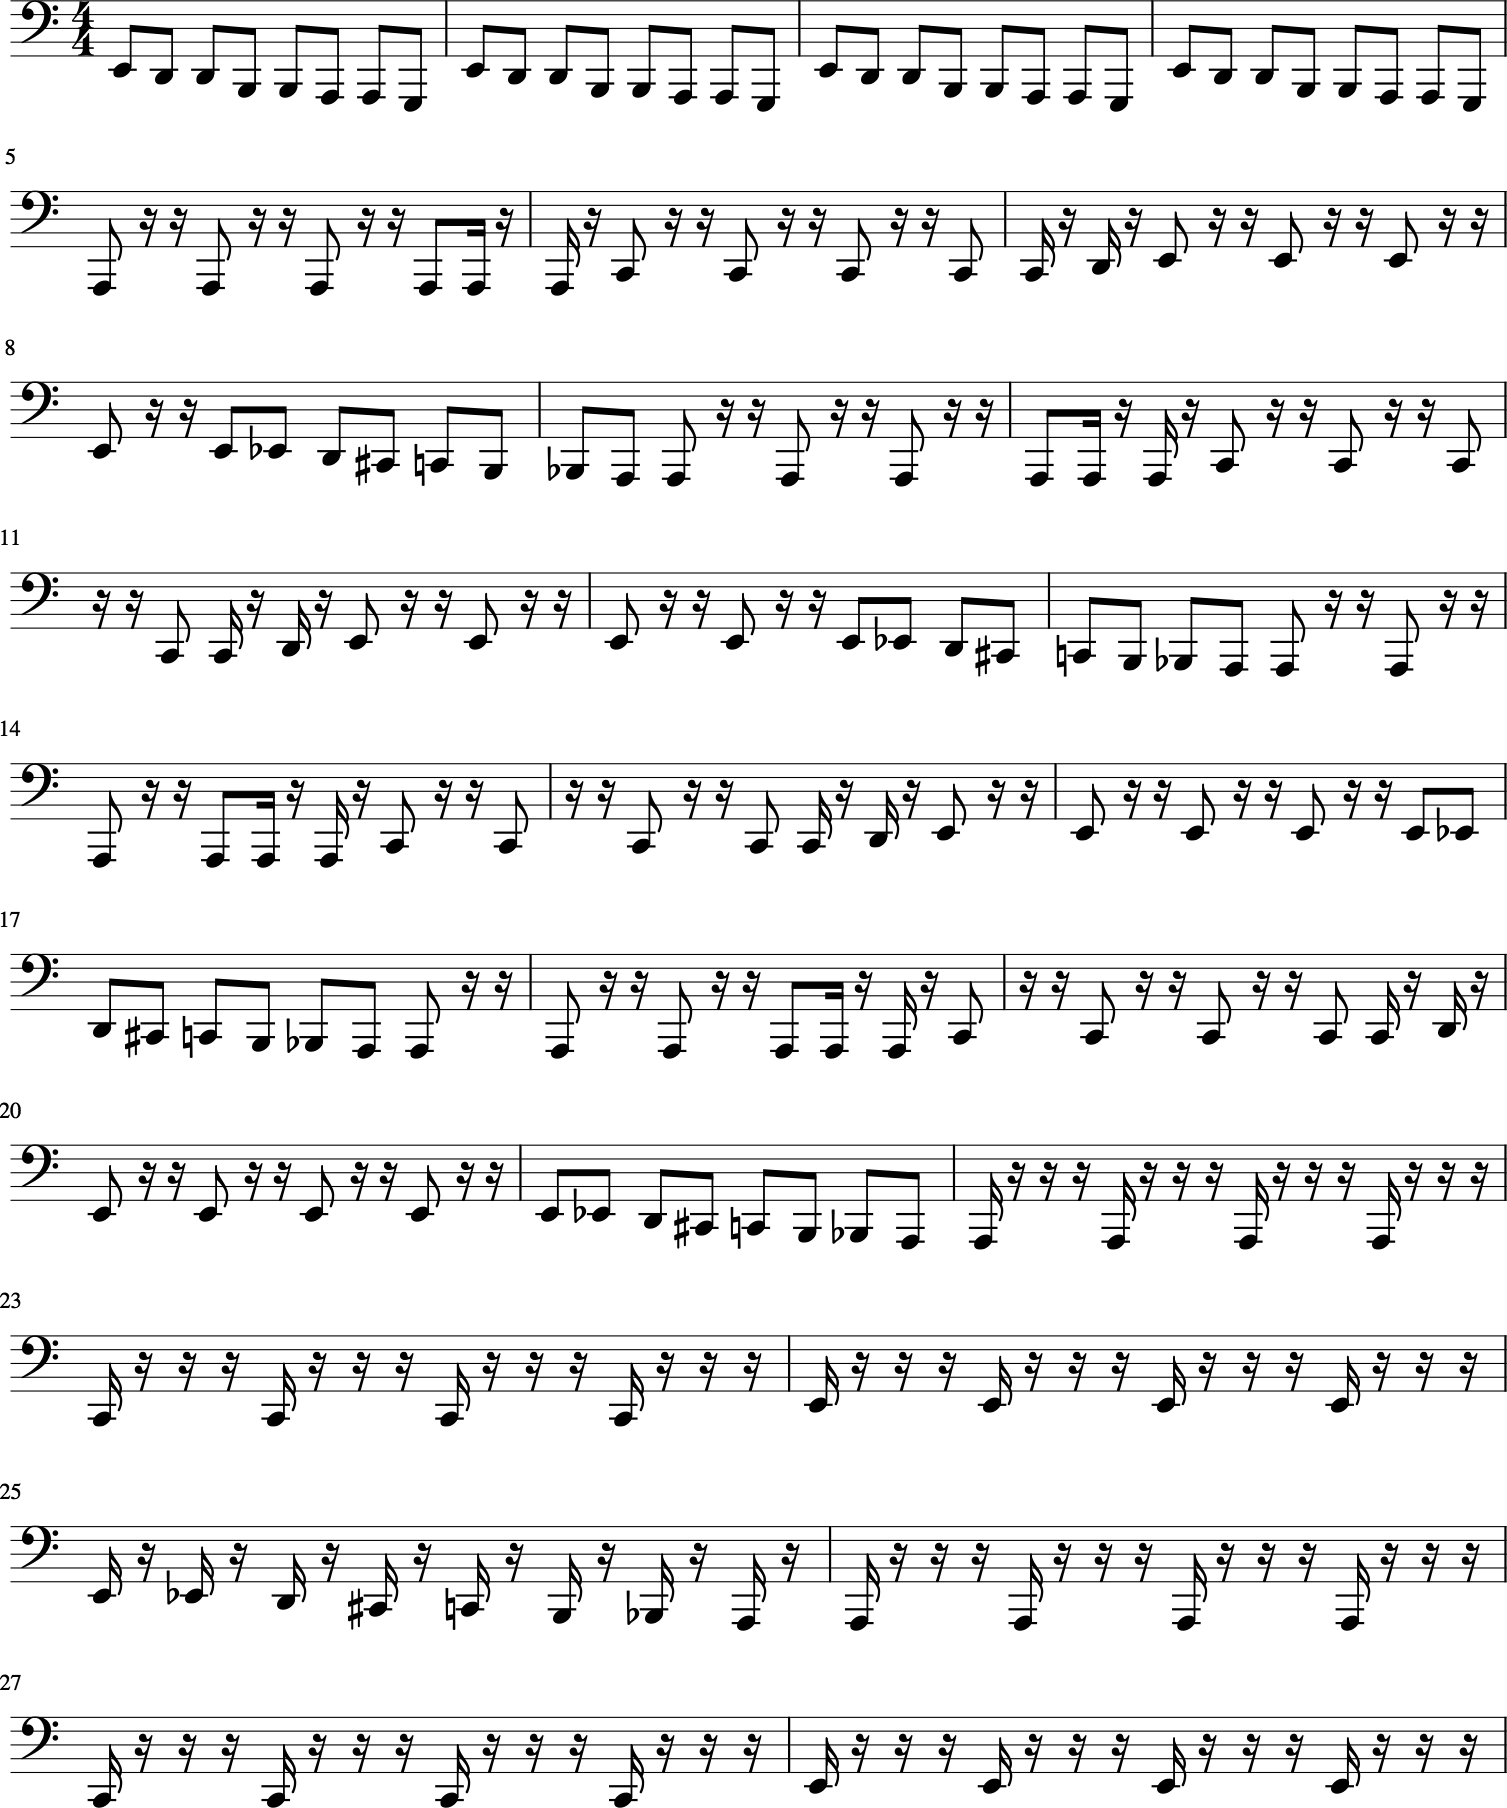

In [17]:
recoded_stream.show()

In [18]:
#sp = music21.midi.realtime.StreamPlayer(recoded_stream)
#sp.play()

In [158]:
part_stream = stream.parts.stream()

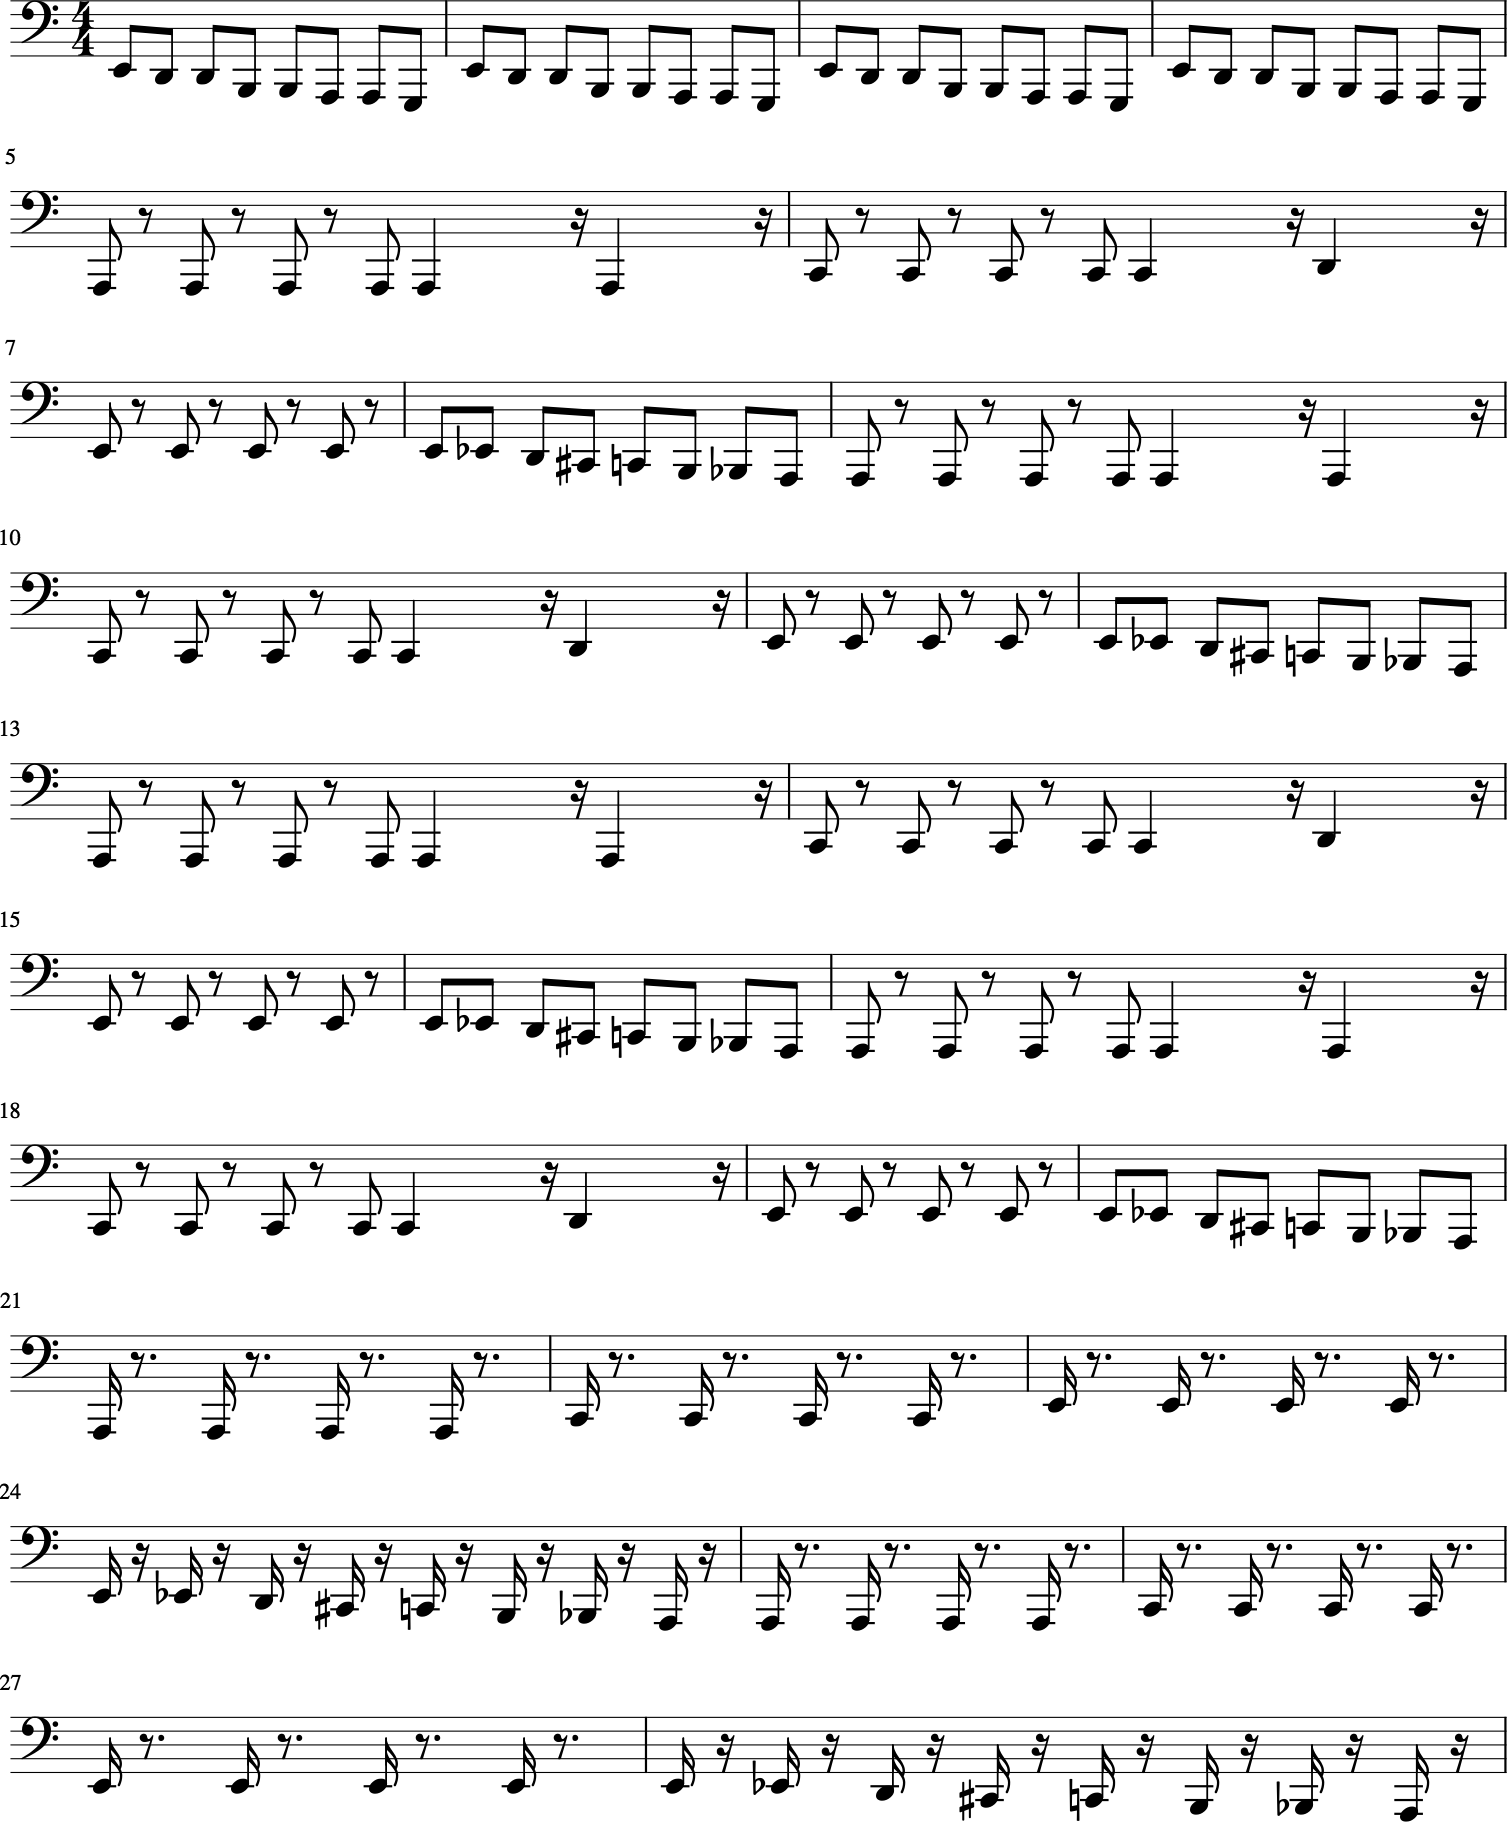

In [122]:
part_stream[2].show()